<a href="https://colab.research.google.com/github/ernesto-miguez/Machine-Learning-training/blob/master/Recommendation_Systems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RECOMMENDATION SYSTEMS WITH TENSORFLOW

## 1. Set Up

In [1]:
from __future__ import print_function

import numpy as np
import pandas as pd
import collections
from mpl_toolkits.mplot3d import Axes3D
from IPython import display
from matplotlib import pyplot as plt
import sklearn
import sklearn.manifold
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

In [2]:
# Add some convenience functions to Pandas DataFrame
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.3f}'.format
def mask(df, key, function):
  return df[function(df[key])]

def flatten_cols(df):
  df.columns = [' '.join(col).strip() for col in df.columns.values]
  return df

pd.DataFrame.mask = mask 
pd.DataFrame.flatten_cols = flatten_cols

# Install Altair and activate its colab renderer
print("Installing Altair...")
!pip install git+git://github.com/altair-viz/altair.git
import altair as alt
alt.data_transformers.enable('default', max_rows=None)
alt.renderers.enable('colab')
print("Done installing Altair.")

# Install spreadsheets and import authentications module
USER_RATINGS = False
!pip install --upgrade -q gspread
from google.colab import auth
import gspread
from oauth2client.client import GoogleCredentials

Installing Altair...
  Cloning git://github.com/altair-viz/altair.git to /tmp/pip-req-build-k84p47z2
  Running command git clone -q git://github.com/altair-viz/altair.git /tmp/pip-req-build-k84p47z2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for altair: filename=altair-4.1.0.dev0-cp36-none-any.whl size=705936 sha256=e5cbe0944c5de6b4206223d816277a99b0c161efe3ed8cd0742e2ee749360335
  Stored in directory: /tmp/pip-ephem-wheel-cache-ca887i8f/wheels/01/fd/91/025b6149b3949af76e93b3b3ceca5bf12cbdebc98fa46f9ec6
Successfully built altair
  Found existing installation: altair 4.0.1
    Uninstalling altair-4.0.1:
      Successfully uninstalled altair-4.0.1
Done installing Altair.


## 2. Download MovieLens Data

In [3]:
# Download MovieLens data.
print("Downloading movielens data...")
from urllib.request import urlretrieve
import zipfile

urlretrieve("http://files.grouplens.org/datasets/movielens/ml-100k.zip", "movielens.zip")
zip_ref = zipfile.ZipFile('movielens.zip', "r")
zip_ref.extractall()
print("Done. Dataset contains:")
print(zip_ref.read('ml-100k/u.info'))

# Load each data set (users, movies, and ratings).
users_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv(
    'ml-100k/u.user', sep='|', names=users_cols, encoding='latin-1')

ratings_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv(
    'ml-100k/u.data', sep='\t', names=ratings_cols, encoding='latin-1')

# The movies file contains a binary feature for each genre.
genre_cols = [
    "genre_unknown", "Action", "Adventure", "Animation", "Children", "Comedy",
    "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror",
    "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"
]
movies_cols = [
    'movie_id', 'title', 'release_date', "video_release_date", "imdb_url"
] + genre_cols
movies = pd.read_csv(
    'ml-100k/u.item', sep='|', names=movies_cols, encoding='latin-1')

# Since the ids start at 1, we shift them to start at 0.
users["user_id"] = users["user_id"].apply(lambda x: str(x-1))
movies["movie_id"] = movies["movie_id"].apply(lambda x: str(x-1))
movies["year"] = movies['release_date'].apply(lambda x: str(x).split('-')[-1])
ratings["movie_id"] = ratings["movie_id"].apply(lambda x: str(x-1))
ratings["user_id"] = ratings["user_id"].apply(lambda x: str(x-1))
ratings["rating"] = ratings["rating"].apply(lambda x: float(x))

# Compute the number of movies to which a genre is assigned.
genre_occurences = movies[genre_cols].sum().to_dict()

# Since some movies can belong to more than one genre, we create different
# 'genre' columns as follows:
# - all_genres: all the active genres of the movie.
# - genre: randomly sampled from the active genres.
def mark_genres(movies, genres):
  def get_random_genre(gs):
    active = [genre for genre, g in zip(genres, gs) if g==1]
    if len(active) == 0:
      return 'Other'
    return np.random.choice(active)
  def get_all_genres(gs):
    active = [genre for genre, g in zip(genres, gs) if g==1]
    if len(active) == 0:
      return 'Other'
    return '-'.join(active)
  movies['genre'] = [
      get_random_genre(gs) for gs in zip(*[movies[genre] for genre in genres])]
  movies['all_genres'] = [
      get_all_genres(gs) for gs in zip(*[movies[genre] for genre in genres])]

mark_genres(movies, genre_cols)

# Create one merged DataFrame containing all the movielens data.
movielens = ratings.merge(movies, on='movie_id').merge(users, on='user_id')

# Utility to split the data into training and test sets.
def split_dataframe(df, holdout_fraction=0.1):
  """Splits a DataFrame into training and test sets.
  Args:
    df: a dataframe.
    holdout_fraction: fraction of dataframe rows to use in the test set.
  Returns:
    train: dataframe for training
    test: dataframe for testing
  """
  test = df.sample(frac=holdout_fraction, replace=False)
  train = df[~df.index.isin(test.index)]
  return train, test

Done. Dataset contains:
b'943 users\n1682 items\n100000 ratings\n'


## 3. Exploring the Movielens Data


In [4]:
users.describe()

age
count 943.000
mean   34.052
std    12.193
min     7.000
25%    25.000
50%    31.000
75%    43.000
max    73.000

In [5]:
users.describe(include=[np.object])

user_id  sex occupation zip_code
count      943  943        943      943
unique     943    2         21      795
top        447    M    student    55414
freq         1  670        196        9

In [6]:
users.head()

user_id  age sex  occupation zip_code
0       0   24   M  technician    85711
1       1   53   F       other    94043
2       2   23   M      writer    32067
3       3   24   M  technician    43537
4       4   33   F       other    15213

## Create histograms to further understand the distribution of the users. We use Altair to create an interactive chart

In [0]:
# Create filter to be used to slice the data
occupation_filter = alt.selection_multi(fields=["occupation"])
occupation_chart = alt.Chart().mark_bar().encode(
    x="count()",
    y=alt.Y("occupation:N"),
    color=alt.condition(
        occupation_filter,
        alt.Color("occupation:N", scale=alt.Scale(scheme='category20')),
        alt.value("lightgray")),
).properties(width=300, height=300, selection=occupation_filter)

# A function that generates a histogram of filtered data
def filtered_hist(field, label, filter):
  base = alt.Chart().mark_bar().encode(
      x=alt.X(field, bin=alt.Bin(maxbins=10), title=label),
      y="count()",
  ).properties(width=300,)
  return alt.layer(
      base.transform_filter(filter),
      base.encode(color=alt.value('lightgray'), opacity=alt.value(.7)),
  ).resolve_scale(y="independent")

In [8]:
users_ratings = (
    ratings
    .groupby('user_id', as_index=False)
    .agg({'rating': ['count', 'mean']})
    .flatten_cols()
    .merge(users, on='user_id')
)

# Create a chart for the count, and one for the mean
alt.hconcat(
    filtered_hist('rating count', '# ratings / user', occupation_filter),
    filtered_hist('rating mean', 'mean user rating', occupation_filter),
    occupation_chart,
    data = users_ratings)

alt.HConcatChart(...)

## Movies

In [0]:
movies_ratings = movies.merge(
    ratings
    .groupby('movie_id', as_index=False)
    .agg({'rating': ['count', 'mean']})
    .flatten_cols(),
    on='movie_id')

genre_filter = alt.selection_multi(fields=['genre'])
genre_chart = alt.Chart().mark_bar().encode(
    x="count()",
    y=alt.Y('genre'),
    color=alt.condition(
        genre_filter,
        alt.Color("genre:N"),
        alt.value('lightgray'))
).properties(height=300, selection=genre_filter)

In [10]:
(movies_ratings[['title', 'rating count', 'rating mean']]
.sort_values('rating count', ascending=False)
.head(10))

title  rating count  rating mean
49                Star Wars (1977)           583        4.358
257                 Contact (1997)           509        3.804
99                    Fargo (1996)           508        4.156
180      Return of the Jedi (1983)           507        4.008
293               Liar Liar (1997)           485        3.157
285    English Patient, The (1996)           481        3.657
287                  Scream (1996)           478        3.441
0                 Toy Story (1995)           452        3.878
299           Air Force One (1997)           431        3.631
120  Independence Day (ID4) (1996)           429        3.438

In [11]:
(movies_ratings[['title', 'rating count', 'rating mean']]
 .mask('rating count', lambda x: x>20)
 .sort_values('rating mean', ascending=False)
 .head(10))

title  ...  rating mean
407                              Close Shave, A (1995)  ...        4.491
317                            Schindler's List (1993)  ...        4.466
168                         Wrong Trousers, The (1993)  ...        4.466
482                                  Casablanca (1942)  ...        4.457
113  Wallace & Gromit: The Best of Aardman Animatio...  ...        4.448
63                    Shawshank Redemption, The (1994)  ...        4.445
602                                 Rear Window (1954)  ...        4.388
11                          Usual Suspects, The (1995)  ...        4.386
49                                    Star Wars (1977)  ...        4.358
177                                12 Angry Men (1957)  ...        4.344

[10 rows x 3 columns]

## Finally, the last chart shows the distribution of the number of ratings and average rating

In [12]:
# Display the number of ratings and average rating per movie
alt.hconcat(
    filtered_hist('rating count', '# ratings / movie', genre_filter),
    filtered_hist('rating mean', 'mean movie rating', genre_filter),
    genre_chart,
    data=movies_ratings)

alt.HConcatChart(...)

## 4. Preliminaries

Our goal is to factorize the ratings matrix $A$ into the product of a user embedding matrix $U$ and movie embedding matrix $V$, such that $A \approx UV^\top$ with
$U = \begin{bmatrix} u_{1} \\ \hline \vdots \\ \hline u_{N} \end{bmatrix}$ and
$V = \begin{bmatrix} v_{1} \\ \hline \vdots \\ \hline v_{M} \end{bmatrix}$.

Here
- $N$ is the number of users,
- $M$ is the number of movies,
- $A_{ij}$ is the rating of the $j$th movies by the $i$th user,
- each row $U_i$ is a $d$-dimensional vector (embedding) representing user $i$,
- each rwo $V_j$ is a $d$-dimensional vector (embedding) representing movie $j$,
- the prediction of the model for the $(i, j)$ pair is the dot product $\langle U_i, V_j \rangle$.

## Exercise 1: Build a tf.SparseTensor representation of the Rating Matrix

In [0]:
def build_rating_sparse_tensor(ratings_df):
  indices = ratings_df[['user_id', 'movie_id']].values
  values = ratings_df['rating'].values
  return tf.SparseTensor(
      indices = indices,
      values = values,
      dense_shape =[users.shape[0], movies.shape[0]])

## Exercise 2: Mean Squared Error

In [0]:
def sparse_mean_squared_error(sparse_ratings, user_embeddings, movie_embeddings):
  predictions = tf.gather_nd(
      tf.matmul(user_embeddings, movie_embeddings, transpose_b=True),
      sparse_ratings.indices)
  loss = tf.losses.mean_squared_error(sparse_ratings.values, predictions)
  return loss

## 5. Training a Matrix Factorization Model

In [0]:
class CFModel(object):

  def __init__(self, embedding_vars, loss, metrics=None):

    self._embedding_vars = embedding_vars
    self._loss = loss
    self._metrics = metrics
    self._embeddings = {k: None for k in embedding_vars}
    self._session = None

  @property
  def embeddings(self):
    return self._embeddings

  def train(self, num_iterations=100, learning_rate=1.0, plot_results=True,
            optimizer=tf.train.GradientDescentOptimizer):
    
    with self._loss.graph.as_default():
      opt = optimizer(learning_rate)
      train_op = opt.minimize(self._loss)
      local_init_op = tf.group(
          tf.variables_initializer(opt.variables()),
          tf.local_variables_initializer())
      if self._session is None:
        self._session = tf.Session()
        with self._session.as_default():
          self._session.run(tf.global_variables_initializer())
          self._session.run(tf.tables_initializer())
          tf.train.start_queue_runners()
    
    with self._session.as_default():
      local_init_op.run()
      iterations = []
      metrics = self._metrics or ({},)
      metrics_vals = [collections.defaultdict(list) for _ in self._metrics]

      # Train and append results
      for i in range(num_iterations + 1):
        _, results = self._session.run((train_op, metrics))
        if (i % 10 == 0) or i == num_iterations:
          print("\r iteration %d: " % i + ", ".join(
              ["%s=%f" % (k, v) for r in results for k, v in r.items()]),
              end='')
          iterations.append(i)
          for metric_val, result in zip(metrics_vals, results):
            for k, v in result.items():
              metric_val[k].append(v)

      for k, v in self._embedding_vars.items():
        self._embeddings[k] = v.eval()

      if plot_results:
        # Plot the metrics
        num_subplots = len(metrics)+1
        fig = plt.figure()
        fig.set_size_inches(num_subplots*10, 8)
        for i, metric_vals in enumerate(metrics_vals):
          ax = fig.add_subplot(1, num_subplots, i+1)
          for k, v in metric_vals.items():
            ax.plot(iterations, v, label=k)
          ax.set_xlim([1, num_iterations])
          ax.legend()
      return results

## Exercise 4: Build a Matrix Factorization model and train it

In [0]:
def build_model(ratings, embedding_dim=3, init_stddev=1.):

  # Split the ratings DataFrame into train and test.
  train_ratings, test_ratings = split_dataframe(ratings)
  # SparseTensor representation of the train and test datasets.
  # ========================= Complete this section ============================
  A_train = build_rating_sparse_tensor(train_ratings)
  A_test = build_rating_sparse_tensor(test_ratings)
  # ============================================================================
  # Initialize the embeddings using a normal distribution.
  U = tf.Variable(tf.random_normal(
      [A_train.dense_shape[0], embedding_dim], stddev=init_stddev))
  V = tf.Variable(tf.random_normal(
      [A_train.dense_shape[1], embedding_dim], stddev=init_stddev))
  # ========================= Complete this section ============================
  train_loss = sparse_mean_squared_error(A_train, U, V)
  test_loss = sparse_mean_squared_error(A_test, U, V)
  # ============================================================================
  metrics = {
      'train_error': train_loss,
      'test_error': test_loss
  }
  embeddings = {
      "user_id": U,
      "movie_id": V
  }
  return CFModel(embeddings, train_loss, [metrics])

 iteration 1000: train_error=0.373750, test_error=1.404325

[{'test_error': 1.4043249, 'train_error': 0.37374964}]

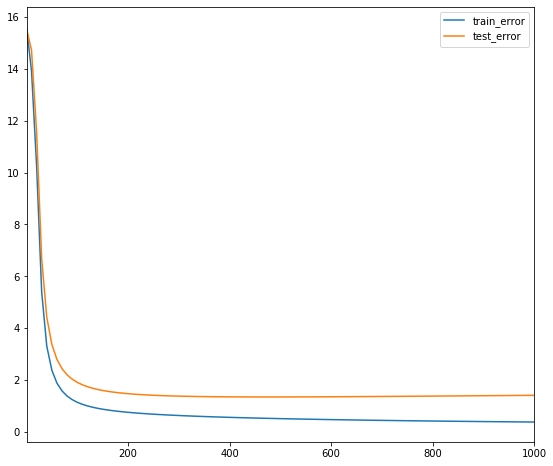

In [17]:
# Build the CF model and train it
model = build_model(ratings, embedding_dim=30, init_stddev=0.5)
model.train(num_iterations=1000, learning_rate=10.)

## Exercise 5: Write a function that computes the scores of the candidates

In [0]:
DOT = 'dot'
COSINE = 'cosine'
def compute_scores(query_embedding, item_embeddings, measure=DOT):
  U = query_embedding
  V = item_embeddings
  if measure == COSINE:
    V = V / np.linalg.norm(V, axis=1, keepdims=True)
    U = U / np.linalg.norm(U)
  scores = U.dot(V.T)
  return scores

## 6. User recommendations and nearest neighbors

In [0]:
def user_recommendations(model, measure=DOT, exclude_rated=False, k=6):
  if USER_RATINGS:
    scores = compute_scores(
        model.embeddings["user_id"][943], model.embeddings["movie_id"], measure)
    score_key = measure + ' score'
    df = pd.DataFrame({
        score_key: list(scores),
        'movie_id': movies['movie_id'],
        'titles': movies['title'],
        'genres': movies['all_genres'],
    })
    if exclude_rated:
      # remove movies that are already rated
      rated_movies = ratings[ratings.user_id == "943"]["movie_id"].values
      df = df[df.movie_id.apply(lambda movie_id: movie_id not in rated_movies)]
    display.display(df.sort_values([score_key], ascending=False).head(k))  

def movie_neighbors(model, title_substring, measure=DOT, k=6):
  # Search for movie ids that match the given substring.
  ids =  movies[movies['title'].str.contains(title_substring)].index.values
  titles = movies.iloc[ids]['title'].values
  if len(titles) == 0:
    raise ValueError("Found no movies with title %s" % title_substring)
  print("Nearest neighbors of : %s." % titles[0])
  if len(titles) > 1:
    print("[Found more than one matching movie. Other candidates: {}]".format(
        ", ".join(titles[1:])))
  movie_id = ids[0]
  scores = compute_scores(
      model.embeddings["movie_id"][movie_id], model.embeddings["movie_id"],
      measure)
  score_key = measure + ' score'
  df = pd.DataFrame({
      score_key: list(scores),
      'titles': movies['title'],
      'genres': movies['all_genres']
  })
  display.display(df.sort_values([score_key], ascending=False).head(k))

In [0]:
user_recommendations(model, measure=COSINE, k=5)

In [21]:
movie_neighbors(model, "Aladdin", DOT)
movie_neighbors(model, "Aladdin", COSINE)

Nearest neighbors of : Aladdin (1992).
[Found more than one matching movie. Other candidates: Aladdin and the King of Thieves (1996)]


dot score  ...                               genres
315      5.387  ...                         Comedy-Drama
63       5.345  ...                                Drama
271      5.297  ...                                Drama
49       5.228  ...  Action-Adventure-Romance-Sci-Fi-War
94       5.156  ...    Animation-Children-Comedy-Musical
317      5.150  ...                            Drama-War

[6 rows x 3 columns]

Nearest neighbors of : Aladdin (1992).
[Found more than one matching movie. Other candidates: Aladdin and the King of Thieves (1996)]


cosine score  ...                             genres
94          1.000  ...  Animation-Children-Comedy-Musical
215         0.904  ...                     Comedy-Romance
63          0.881  ...                              Drama
27          0.870  ...              Action-Drama-Thriller
209         0.864  ...                   Action-Adventure
81          0.863  ...            Action-Adventure-Sci-Fi

[6 rows x 3 columns]

## Movie Embedding Norm

In [0]:
# Embedding Visualization code

def movie_embedding_norm(models):
  if not isinstance(models, list):
    models = [models]
  df = pd.DataFrame({
      'title': movies['title'],
      'genre': movies['genre'],
      'num_ratings': movies_ratings['rating count'],
  })
  charts = []
  brush = alt.selection_interval()
  for i, model in enumerate(models):
    norm_key = 'norm'+str(i)
    df[norm_key] = np.linalg.norm(model.embeddings["movie_id"], axis=1)
    nearest = alt.selection(
        type='single', encodings=['x', 'y'], on='mouseover', nearest=True,
        empty='none')
    base = alt.Chart().mark_circle().encode(
        x='num_ratings',
        y=norm_key,
        color=alt.condition(brush, alt.value('#4c78a8'), alt.value('lightgray'))
    ).properties(
        selection=nearest).add_selection(brush)
    text = alt.Chart().mark_text(align='center', dx=5, dy=5).encode(
        x='num_ratings', y=norm_key,
        text=alt.condition(nearest, 'title', alt.value('')))
    charts.append(alt.layer(base, text))
  return alt.hconcat(*charts, data=df)

def visualize_movie_embeddings(data, x, y):
  nearest = alt.selection(
      type='single', encodings=['x', 'y'], on='mouseover', nearest=True,
      empty='none')
  base = alt.Chart().mark_circle().encode(
      x=x,
      y=y,
      text=alt.condition(genre_filter, 'genre', alt.value('whitesmoke')),
      ).properties(
          width=600,
          height=600,
          selection=nearest)
  text = alt.Chart().mark_text(align='left', dx=5, dy=-5).encode(
      x=x,
      y=y,
      text=alt.condition(nearest, 'title', alt.value('')))
  return alt.hconcat(alt.layer(base, text), genre_chart, data=data)

def tsne_movie_embeddings(model):
  tsne = sklearn.manifold.TSNE(
      n_components = 2, perplexity=40, metric='cosine', early_exaggeration=10.0,
      init='pca', verbose=True, n_iter=400)
  
  print('Running t-SNE...')
  V_proj = tsne.fit_transform(model.embeddings["movie_id"])
  movies.loc[:,'x'] = V_proj[:, 0]
  movies.loc[:,'y'] = V_proj[:, 1]
  return visualize_movie_embeddings(movies, 'x', 'y')


In [23]:
movie_embedding_norm(model)

alt.HConcatChart(...)

Note: Depending on how the model is initialized, you may observe that some niche movies (ones with few ratings) have a high norm, leading to spurious recommendations. This can happen if the embedding of that movie happens to be initialized with a high norm. Then, because the movie has few ratings, it is infrequently updated, and can keep its high norm. This will be alleviated by using regularization.

Try changing the value of the hyper-parameter `init_stddev`. One quantity that can be helpful is that the expected norm of a $d$-dimensional vector with entries $\sim \mathcal N(0, \sigma^2)$ is approximatley $\sigma \sqrt d$.

How does this affect the embedding norm distribution, and the ranking of the top-norm movies?


 iteration 1000: train_error=0.355602, test_error=0.968995Nearest neighbors of : Aladdin (1992).
[Found more than one matching movie. Other candidates: Aladdin and the King of Thieves (1996)]


dot score  ...                                     genres
94       5.631  ...          Animation-Children-Comedy-Musical
49       5.245  ...        Action-Adventure-Romance-Sci-Fi-War
171      5.105  ...  Action-Adventure-Drama-Romance-Sci-Fi-War
180      5.089  ...        Action-Adventure-Romance-Sci-Fi-War
11       4.905  ...                             Crime-Thriller
14       4.863  ...                                      Drama

[6 rows x 3 columns]

Nearest neighbors of : Aladdin (1992).
[Found more than one matching movie. Other candidates: Aladdin and the King of Thieves (1996)]


cosine score  ...                             genres
94           1.000  ...  Animation-Children-Comedy-Musical
72           0.858  ...              Action-Comedy-Western
1310         0.848  ...                       Comedy-Drama
1357         0.839  ...                             Action
1370         0.835  ...                      Comedy-Horror
544          0.833  ...                     Comedy-Romance

[6 rows x 3 columns]

alt.HConcatChart(...)

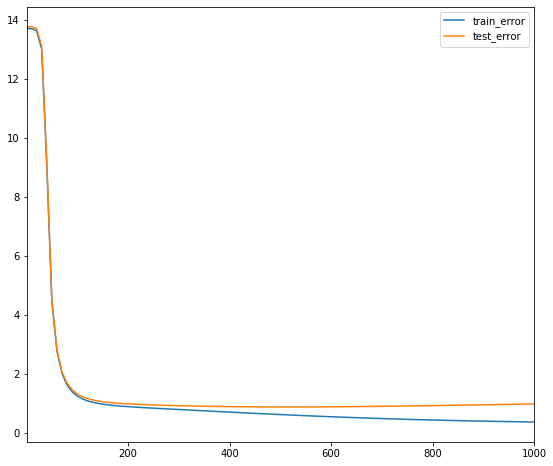

In [24]:
model_lowinit = build_model(ratings, embedding_dim=30, init_stddev=0.05)
model_lowinit.train(num_iterations=1000, learning_rate=10.)
movie_neighbors(model_lowinit, "Aladdin", DOT)
movie_neighbors(model_lowinit, "Aladdin", COSINE)
movie_embedding_norm([model, model_lowinit])

In [25]:
tsne_movie_embeddings(model_lowinit)

Running t-SNE...
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1682 samples in 0.001s...
[t-SNE] Computed neighbors for 1682 samples in 0.164s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1682
[t-SNE] Computed conditional probabilities for sample 1682 / 1682
[t-SNE] Mean sigma: 0.117077
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.020592
[t-SNE] KL divergence after 400 iterations: 2.236774


alt.HConcatChart(...)

We can observe that the embeddings do not seem to have any notable structure, and the embeddings of a given genre are located all over the embedding space. This confirms the poor quality of the learned embeddings. One of the main reasons, which we will address in the next section, is that we only trained the model on observed pairs, and without regularization.

## 7. Regularization In Matrix Factorization

In the previous section, our loss was defined as the mean squared error on the observed part of the rating matrix.  As discussed in the lecture, this can be problematic as the model does not learn how to place the embeddings of irrelevant movies. This phenomenon is known as *folding*.

We will add regularization terms that will address this issue. We will use two types of regularization:
- Regularization of the model parameters. This is a common $\ell_2$ regularization term on the embedding matrices, given by $r(U, V) =  \frac{1}{N} \sum_i \|U_i\|^2 + \frac{1}{M}\sum_j \|V_j\|^2$.
- A global prior that pushes the prediction of any pair towards zero, called the *gravity* term. This is given by $g(U, V) = \frac{1}{MN} \sum_{i = 1}^N \sum_{j = 1}^M \langle U_i, V_j \rangle^2$.

The total loss is then given by
$$
\frac{1}{|\Omega|}\sum_{(i, j) \in \Omega} (A_{ij} - \langle U_i, V_j\rangle)^2 + \lambda _r r(U, V) + \lambda_g g(U, V)
$$
where $\lambda_r$ and $\lambda_g$ are two regularization coefficients (hyper-parameters).

## Exercise 6: Build a regularized Matrix Factorization model and train it 

In [0]:
def gravity(U, V):
  return 1. / (U.shape[0].value*V.shape[0].value) * tf.reduce_sum(
      tf.matmul(U, U, transpose_a=True) * tf.matmul(V, V, transpose_a=True))
  
def build_regularized_model(
    ratings, embedding_dim=3, regularization_coeff=.1, gravity_coeff=1.,
    init_stddev=0.1):
  
  # Split the ratings DataFrame into train and test
  train_ratings, test_ratings = split_dataframe(ratings)
  # SparseTensor representation of the train and test datsets
  A_train = build_rating_sparse_tensor(train_ratings)
  A_test = build_rating_sparse_tensor(test_ratings)
  U = tf.Variable(tf.random_normal(
      [A_train.dense_shape[0], embedding_dim], stddev = init_stddev))
  V = tf.Variable(tf.random_normal(
      [A_train.dense_shape[1], embedding_dim], stddev = init_stddev))
  
  error_train = sparse_mean_squared_error(A_train, U, V)
  error_test = sparse_mean_squared_error(A_test, U, V)
  gravity_loss = gravity_coeff * gravity(U, V)
  regularization_loss = regularization_coeff * (
      tf.reduce_sum(U*U)/U.shape[0].value + tf.reduce_sum(V*V)/V.shape[0].value)
  total_loss = error_train + regularization_loss + gravity_loss
  losses = {
      'train_error_observed': error_train,
      'test_error_observed': error_test,
  }
  loss_components = {
      'observed_loss': error_train,
      'regularization_loss': regularization_loss,
      'gravity_loss': gravity_loss
  }
  embeddings = {'user_id': U, "movie_id": V}
  return CFModel(embeddings, total_loss, [losses, loss_components])

 iteration 2000: train_error_observed=3.216833, test_error_observed=3.317170, observed_loss=3.216833, regularization_loss=2.545949, gravity_loss=1.156061

[{'test_error_observed': 3.3171704, 'train_error_observed': 3.2168326},
 {'gravity_loss': 1.156061,
  'observed_loss': 3.2168326,
  'regularization_loss': 2.5459485}]

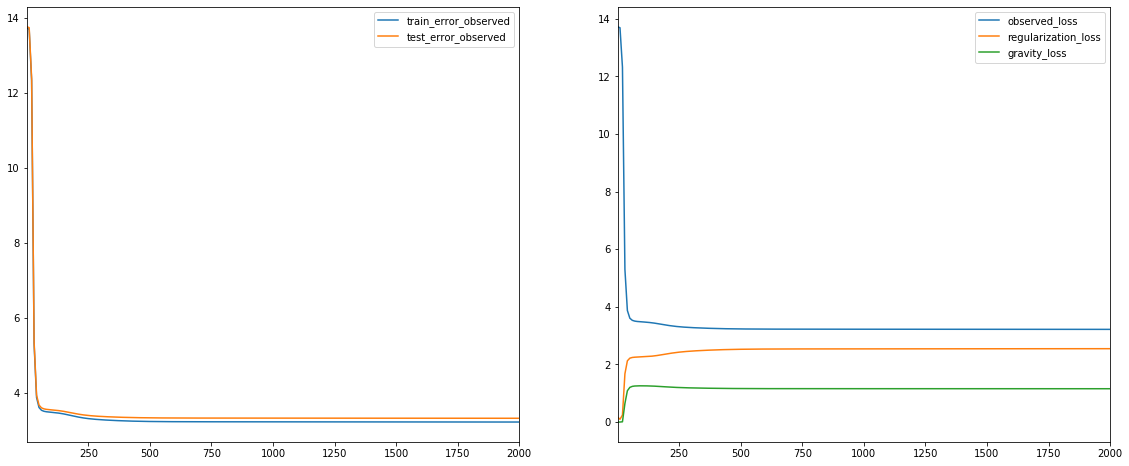

In [27]:
reg_model = build_regularized_model(
    ratings, regularization_coeff=1.0, embedding_dim=35, 
    init_stddev=.05)
reg_model.train(num_iterations = 2000, learning_rate=20.)

In [0]:
user_recommendations(reg_model, DOT, exclude_rated=True, k=10)

In [29]:
movie_neighbors(reg_model, "Aladdin", DOT)
movie_neighbors(reg_model, "Aladdin", COSINE)

Nearest neighbors of : Aladdin (1992).
[Found more than one matching movie. Other candidates: Aladdin and the King of Thieves (1996)]


dot score  ...                                     genres
49       6.196  ...        Action-Adventure-Romance-Sci-Fi-War
173      5.726  ...                           Action-Adventure
180      5.656  ...        Action-Adventure-Romance-Sci-Fi-War
126      5.534  ...                         Action-Crime-Drama
97       5.530  ...                             Drama-Thriller
171      5.481  ...  Action-Adventure-Drama-Romance-Sci-Fi-War

[6 rows x 3 columns]

Nearest neighbors of : Aladdin (1992).
[Found more than one matching movie. Other candidates: Aladdin and the King of Thieves (1996)]


cosine score  ...                             genres
94           1.000  ...  Animation-Children-Comedy-Musical
143          0.999  ...                    Action-Thriller
567          0.999  ...            Action-Romance-Thriller
264          0.999  ...                    Action-Thriller
1059         0.998  ...                 Adventure-Children
81           0.998  ...            Action-Adventure-Sci-Fi

[6 rows x 3 columns]

In [30]:
movie_embedding_norm([model, model_lowinit, reg_model])

alt.HConcatChart(...)

In [31]:
tsne_movie_embeddings(reg_model)

Running t-SNE...
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1682 samples in 0.000s...
[t-SNE] Computed neighbors for 1682 samples in 0.174s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1682
[t-SNE] Computed conditional probabilities for sample 1682 / 1682
[t-SNE] Mean sigma: 0.046968
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.567436
[t-SNE] KL divergence after 400 iterations: 0.657371


alt.HConcatChart(...)

Conclusion

This concludes this section on matrix factorization models. Note that while the scale of the problem is small enough to allow efficient training using SGD, many practical problems need to be trained using more specialized algorithms such as Alternating Least Squares

## 8. Softmax model

In [33]:
rated_movies = (ratings[["user_id", "movie_id"]]
                .groupby("user_id", as_index=False)
                .aggregate(lambda x: list(x)))
rated_movies.head()

user_id                                           movie_id
0       0  [60, 188, 32, 159, 19, 201, 170, 264, 154, 116...
1       1  [291, 250, 49, 313, 296, 289, 311, 280, 12, 27...
2      10  [110, 557, 731, 226, 424, 739, 722, 37, 724, 1...
3     100  [828, 303, 595, 221, 470, 404, 280, 251, 281, ...
4     101  [767, 822, 69, 514, 523, 321, 624, 160, 447, 4...

We then create a function that generates an example batch, such that each example contains the following features:
- movie_id: A tensor of strings of the movie ids that the user rated.
- genre: A tensor of strings of the genres of those movies
- year: A tensor of strings of the release year.

In [0]:
years_dict = {
    movie: year for movie, year in zip(movies["movie_id"], movies["year"])
}

genres_dict = {
    movie: genres.split('-')
    for movie, genres in zip(movies["movie_id"], movies["all_genres"])
}

def make_batch(ratings, batch_size):

  def pad(x, fill):
    return pd.DataFrame.from_dict(x).fillna(fill).values

  movie = []
  year = []
  genre = []
  label = []
  for movie_ids in ratings["movie_id"].values:
    movie.append(movie_ids)
    genre.append([x for movie_id in movie_ids for x in genres_dict[movie_id]])
    year.append([years_dict[movie_id] for movie_id in movie_ids])
    label.append([int(movie_id) for movie_id in movie_ids])
  features = {
      "movie_id": pad(movie, ""),
      "year": pad(year, ""),
      "genre": pad(genre, ""),
      "label": pad(label, -1)
  }
  batch = (
      tf.data.Dataset.from_tensor_slices(features)
      .shuffle(1000)
      .repeat()
      .batch(batch_size)
      .make_one_shot_iterator()
      .get_next())
  return batch

def select_random(x):
  def to_float(x):
    return tf.cast(x, tf.float32)
  def to_int(x):
    return tf.cast(x, tf.int64)
  batch_size = tf.shape(x)[0]
  rn = tf.range(batch_size)
  nnz = to_float(tf.count_nonzero(x >=0, axis=1))
  rnd = tf.random_uniform([batch_size])
  ids = tf.stack([to_int(rn), to_int(nnz * rnd)], axis=1)
  return to_int(tf.gather_nd(x, ids))

## Exercise 7: Write a loss function for the softmax model

In [0]:
def softmax_loss(user_embeddings, movie_embeddings, labels):
  
  # Verify that the embeddings have compatible dimensions
  user_emb_dim = user_embeddings.shape[1].value
  movie_emb_dim = movie_embeddings.shape[1].value
  if user_emb_dim != movie_emb_dim:
    raise ValueError(
        "The user embeddings dimension %d should match the movie embedding "
        "dimension % d" % (user_emb_dim, movie_emb_dim))
  
  logits = tf.matmul(user_embeddings, movie_embeddings, transpose_b=True)
  loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
      logits=logits, labels=labels))
  return loss

### Exercise 8: Build a softmax model, train it, and inspect its embeddings.

We are now ready to build a softmax CFModel. Complete the `build_softmax_model` function in the next cell. The architecture of the model is defined in the function `create_user_embeddings` and illustrated in the figure below. The input embeddings (movie_id, genre and year) are concatenated to form the input layer, then we have hidden layers with dimensions specified by the `hidden_dims` argument. Finally, the last hidden layer is multiplied by the movie embeddings to obtain the logits layer. For the target label, we will use a randomly-sampled movie_id from the list of movies the user rated.

![Softmax model](https://github.com/google/eng-edu/blob/master/ml/recommendation-systems/images/softmax-model.png?raw=true)

Complete the function below by creating the feature columns and embedding columns, then creating the loss tensors both for the train and test sets (using the `softmax_loss` function of the previous exercise)

In [0]:
def build_softmax_model(rated_movies, embedding_cols, hidden_dims):
  def create_network(features):
    # Create a bag-of-words embedding for each sparse feature
    inputs = tf.feature_column.input_layer(features, embedding_cols)
    # Hidden layers
    input_dim = inputs.shape[1].value
    for i, output_dim in enumerate(hidden_dims):
      w = tf.get_variable(
          "hidden%d_w_" % i, shape=[input_dim, output_dim],
          initializer=tf.truncated_normal_initializer(
              stddev=1./np.sqrt(output_dim))) / 10.
      outputs = tf.matmul(inputs, w)
      input_dim = output_dim
      inputs = outputs
    return outputs


  train_rated_movies, test_rated_movies = split_dataframe(rated_movies)
  train_batch = make_batch(train_rated_movies, 200)
  test_batch = make_batch(test_rated_movies, 100)

  with tf.variable_scope("model", reuse=False):
    # Train
    train_user_embeddings = create_network(train_batch)
    train_labels = select_random(train_batch["label"])
  with tf.variable_scope("model", reuse=True):
    # Test 
    test_user_embeddings = create_network(test_batch)
    test_labels = select_random(test_batch["label"])
    movie_embeddings = tf.get_variable(
        "input_layer/movie_id_embedding/embedding_weights")
    
  test_loss = softmax_loss(
      test_user_embeddings, movie_embeddings, test_labels)
  train_loss = softmax_loss(
      train_user_embeddings, movie_embeddings, train_labels)
  _, test_precision_at_10 = tf.metrics.precision_at_k(
      labels = test_labels,
      predictions = tf.matmul(test_user_embeddings, movie_embeddings, transpose_b=True),
      k = 10)
  
  metrics = (
      {"train_loss": train_loss, "test_loss": test_loss},
      {"test_precision_at_10": test_precision_at_10}
  )
  embeddings = {"movie_id": movie_embeddings}
  return CFModel(embeddings, train_loss, metrics)

In [0]:
def build_softmax_model(rated_movies, embedding_cols, hidden_dims):
  """Builds a Softmax model for MovieLens.
  Args:
    rated_movies: DataFrame of traing examples.
    embedding_cols: A dictionary mapping feature names (string) to embedding
      column objects. This will be used in tf.feature_column.input_layer() to
      create the input layer.
    hidden_dims: int list of the dimensions of the hidden layers.
  Returns:
    A CFModel object.
  """
  def create_network(features):
    """Maps input features dictionary to user embeddings.
    Args:
      features: A dictionary of input string tensors.
    Returns:
      outputs: A tensor of shape [batch_size, embedding_dim].
    """
    # Create a bag-of-words embedding for each sparse feature.
    inputs = tf.feature_column.input_layer(features, embedding_cols)
    # Hidden layers.
    input_dim = inputs.shape[1].value
    for i, output_dim in enumerate(hidden_dims):
      w = tf.get_variable(
          "hidden%d_w_" % i, shape=[input_dim, output_dim],
          initializer=tf.truncated_normal_initializer(
              stddev=1./np.sqrt(output_dim))) / 10.
      outputs = tf.matmul(inputs, w)
      input_dim = output_dim
      inputs = outputs
    return outputs

  train_rated_movies, test_rated_movies = split_dataframe(rated_movies)
  train_batch = make_batch(train_rated_movies, 200)
  test_batch = make_batch(test_rated_movies, 100)

  with tf.variable_scope("model", reuse=False):
    # Train
    train_user_embeddings = create_network(train_batch)
    train_labels = select_random(train_batch["label"])
  with tf.variable_scope("model", reuse=True):
    # Test
    test_user_embeddings = create_network(test_batch)
    test_labels = select_random(test_batch["label"])
    movie_embeddings = tf.get_variable(
        "input_layer/movie_id_embedding/embedding_weights")

  test_loss = softmax_loss(
      test_user_embeddings, movie_embeddings, test_labels)
  train_loss = softmax_loss(
      train_user_embeddings, movie_embeddings, train_labels)
  _, test_precision_at_10 = tf.metrics.precision_at_k(
      labels=test_labels,
      predictions=tf.matmul(test_user_embeddings, movie_embeddings, transpose_b=True),
      k=10)

  metrics = (
      {"train_loss": train_loss, "test_loss": test_loss},
      {"test_precision_at_10": test_precision_at_10}
  )
  embeddings = {"movie_id": movie_embeddings}
  return CFModel(embeddings, train_loss, metrics)

## Train the softmax model

 iteration 3000: train_loss=5.603869, test_loss=5.842732, test_precision_at_10=0.011278

({'test_loss': 5.842732, 'train_loss': 5.6038694},
 {'test_precision_at_10': 0.01127790736421193})

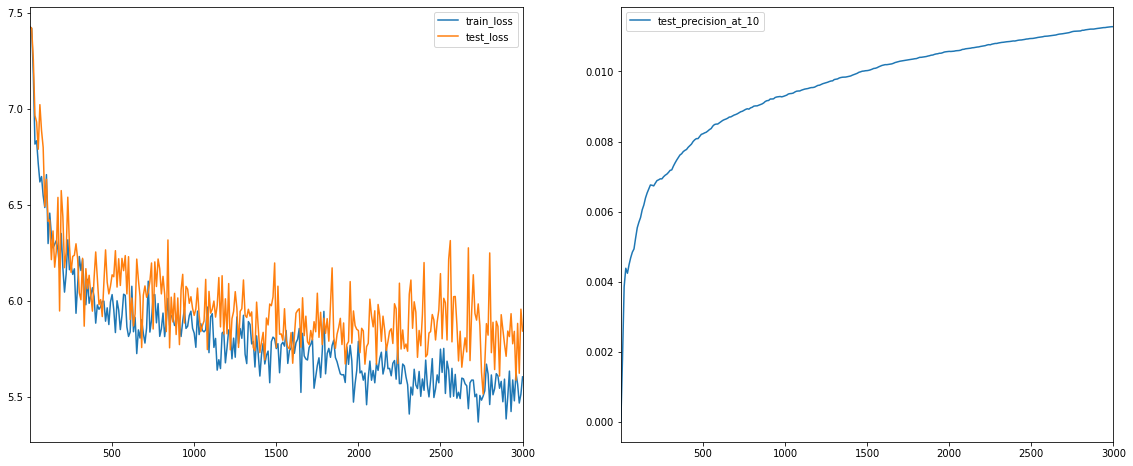

In [57]:
# Create feature embedding columns
def make_embedding_col(key, embedding_dim):
  categorical_col = tf.feature_column.categorical_column_with_vocabulary_list(
      key=key, vocabulary_list=list(set(movies[key].values)), num_oov_buckets=0)
  return tf.feature_column.embedding_column(
      categorical_column = categorical_col, dimension=embedding_dim, combiner='mean')
  
with tf.Graph().as_default():
  softmax_model = build_softmax_model(
      rated_movies,
      embedding_cols=[
          make_embedding_col("movie_id", 35),
          make_embedding_col("genre", 3),
          make_embedding_col("year", 2),
      ],
      hidden_dims=[35])

softmax_model.train(
    learning_rate=8., num_iterations=3000, optimizer=tf.train.AdagradOptimizer)

## Inspect the embeddings

In [58]:
movie_neighbors(softmax_model, "Aladdin", DOT)
movie_neighbors(softmax_model, "Aladdin", COSINE)

Nearest neighbors of : Aladdin (1992).
[Found more than one matching movie. Other candidates: Aladdin and the King of Thieves (1996)]


dot score                      titles                               genres
172     18.485  Princess Bride, The (1987)      Action-Adventure-Comedy-Romance
0       18.453            Toy Story (1995)            Animation-Children-Comedy
116     18.090            Rock, The (1996)            Action-Adventure-Thriller
180     17.938   Return of the Jedi (1983)  Action-Adventure-Romance-Sci-Fi-War
94      17.701              Aladdin (1992)    Animation-Children-Comedy-Musical
27      16.820            Apollo 13 (1995)                Action-Drama-Thriller

Nearest neighbors of : Aladdin (1992).
[Found more than one matching movie. Other candidates: Aladdin and the King of Thieves (1996)]


cosine score  ...                             genres
94          1.000  ...  Animation-Children-Comedy-Musical
587         0.902  ...         Animation-Children-Musical
431         0.879  ...         Animation-Children-Musical
70          0.860  ...         Animation-Children-Musical
90          0.842  ...            Children-Comedy-Musical
81          0.807  ...            Action-Adventure-Sci-Fi

[6 rows x 3 columns]

In [59]:
movie_embedding_norm([reg_model, softmax_model])

alt.HConcatChart(...)

In [60]:
tsne_movie_embeddings(softmax_model)

Running t-SNE...
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1682 samples in 0.000s...
[t-SNE] Computed neighbors for 1682 samples in 0.112s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1682
[t-SNE] Computed conditional probabilities for sample 1682 / 1682
[t-SNE] Mean sigma: 0.188132
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.454472
[t-SNE] KL divergence after 400 iterations: 1.248792


alt.HConcatChart(...)